# Modelling

In [171]:
import pandas as pd
import numpy as np
import datetime
import time

%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, recall_score
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.utils import resample # to under-sample majority class
from imblearn.over_sampling import SMOTE # to over-sample minority class


In [2]:
fulldata = pd.read_csv("../data/data_input_for_model.csv")
# fulldata.drop('Unnamed: 0', axis=1, inplace=True)

# lets remove 2012, as it is the first year, it has no "had_violation_lastyear"
fulldata = fulldata[fulldata.year > 2012]

fulldata.head().T

,1,2,3,4,5
pwsid,CT0010024,CT0010024,CT0010024,CT0010024,CT0010024
pws_name,ANDOVER TOWN HALL & FIRE DEPARTMENT,ANDOVER TOWN HALL & FIRE DEPARTMENT,ANDOVER TOWN HALL & FIRE DEPARTMENT,ANDOVER TOWN HALL & FIRE DEPARTMENT,ANDOVER TOWN HALL & FIRE DEPARTMENT
primacy_agency_code,CT,CT,CT,CT,CT
pws_type_code,TNCWS,TNCWS,TNCWS,TNCWS,TNCWS
gw_sw_code,GW,GW,GW,GW,GW
owner_type_code,P,P,P,P,P
population_served_count,25,25,25,25,25
primary_source_code,GW,GW,GW,GW,GW
is_wholesaler_ind,N,N,N,N,N
is_school_or_daycare_ind,N,N,N,N,N


In [3]:
# select features for modelling
features = ['primacy_agency_code', 'pws_type_code',
           'gw_sw_code', 'owner_type_code', 'population_served_count',
           'primary_source_code', 'is_wholesaler_ind', 'is_school_or_daycare_ind',
           'service_connections_count',
           'year', 
            'had_violation_lastyear', 
            'had_violation', 
           'had_pesticide_violation',
           'had_pesticide_violation_lastyear']
data = fulldata[features]

In [4]:
# get dummies:
# (on the contrary to R, this is needed in python as it is not done automatically by the fitting function)
data = pd.get_dummies(data)

Only three variables seem to have a some correlation with the outcome (*had_violation* or *had_pesticide_violation*): *pws_type_code*, *year* and especially *had_violation_lastyear*.

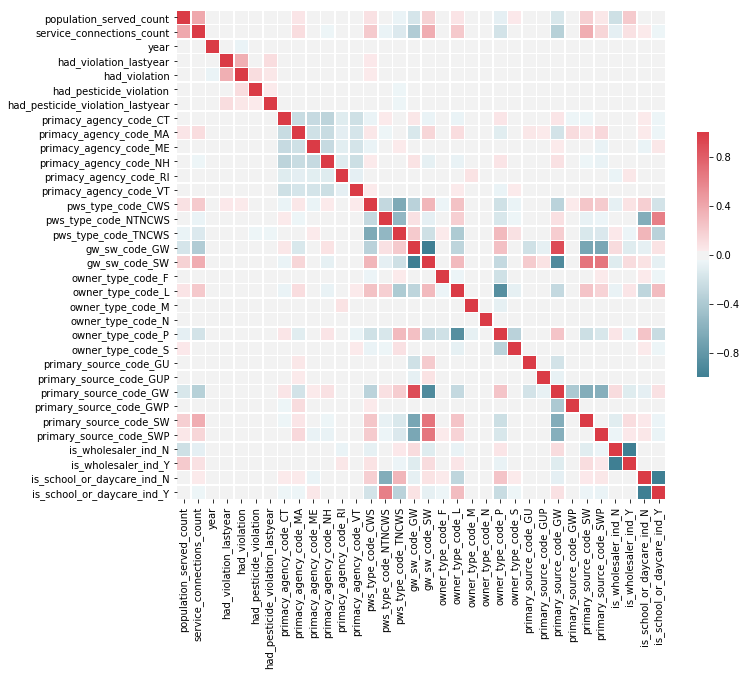

In [5]:
corr = data.corr() 

# heatmap of correlations:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True) # Generate a custom diverging colormap
# Draw the heatmap with the correct aspect ratio:
sns.heatmap(corr, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

We can get rid of some variables that are autocorrelated:

In [6]:
# gw_sw_code_GW and gw_sw_code_SW, as they are highly correlated with primary_source_code and less precise,

# and is_wholesaler_ind_N and is_school_or_daycare_ind_N, as they are binary and thus
# highly correlated with their Y complement,

# TODO: ? remove year, remove service_connections_count

data.drop(['gw_sw_code_GW', 'gw_sw_code_SW', 'is_wholesaler_ind_N', 'is_school_or_daycare_ind_N',
          'year', 'service_connections_count'], 
          axis=1, inplace=True)


## Standardizing the Data

We will do a _0-1 scaling_: 0-1 scaling: (Value - min Value)/(max Value - min Value).


In [7]:
data_std = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

In [8]:
data_std.year.unique()

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

## Trying First a Model to Predict All Violations (no focus on pesticides)

Using *had_violation* as outcome variable.  



### Splitting in Train, Validation and Test Sets
We use the years 2013 to 2016 as train set, the year 2017 as validation set and the year 2018 as test set.

In [9]:
# SPLITTING IN TRAIN AND TEST:

# let's train to test data on 2013-2017 and predict 2017:
data_train = data_std[data_std.year < 0.8] # 2013, 2014, 2015, 2016
data_valid = data_std[data_std.year == 0.8] # 2017
data_test = data_std[data_std.year > 0.8] # 2018

X_train = data_train.drop('had_violation', axis=1)
X_valid = data_valid.drop('had_violation', axis=1)
X_test = data_test.drop('had_violation', axis=1)

y_train = data_train.had_violation
y_valid = data_valid.had_violation
y_test = data_test.had_violation


### First Training a Logistic Regression with Ridge Regularization (L2)

This is a first try to evaluate if the model has some accuracy and what are the potential issues and important features.

In [10]:
# first grid search to optimize C (lambda)
ridge = LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced') # tries to handle class imbalance 
parameter = {'C':[0.1, 1, 10, 100, 1000, 10000]} 
# 5-fold CV and grid search to find the best C:
ridge_f = GridSearchCV(estimator=ridge, scoring='accuracy', param_grid=parameter, cv=5)
ridge_f.fit(X_train, y_train) # this is done -implicitely- with the best_estimator_ found with GridSearchCV
print('Best C:',ridge_f.best_estimator_.C) 
print('The mean cross-validated score of the best_estimator on X_train:', ridge_f.best_score_)
print('Accuracy on (full) X_train: ' + str(ridge_f.score(X_train, y_train)))


Best C: 0.1
The mean cross-validated score of the best_estimator on X_train: 0.7431238659153854
Accuracy on (full) X_train: 0.8690669468054627


In [11]:
# second grid search based on previous best C:
parameter = {'C':[0.0001, 0.001, 0.01, 0.1, 0.5]} 
# 5-fold CV and grid search to find the best C:
ridge_f = GridSearchCV(estimator=ridge, scoring='accuracy', param_grid=parameter, cv=5)
ridge_f.fit(X_train, y_train) # this is done -implicitely- with the best_estimator_ found with GridSearchCV
print('Best C:',ridge_f.best_estimator_.C) 
print('The mean cross-validated score of the best_estimator on X_train:', ridge_f.best_score_)
print('Accuracy on (full) X_train: ' + str(ridge_f.score(X_train, y_train)))


Best C: 0.001
The mean cross-validated score of the best_estimator on X_train: 0.8494890650367682
Accuracy on (full) X_train: 0.8558399388788082


I will continue with C = 0.001. Overfitting seems to be ok. Let's evaluate this model a bit more in detail:  

In [12]:
# Fitting the model with the chosen regularization:
logit_ridge = LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced', C=0.001)
logit_ridge.fit(X_train, y_train)

# A way to estimate the most important features:
print(np.exp([np.std(X_train, 0)]*logit_ridge.coef_)) # "standardized" odds ratios. 
# They are around 1, but there is not confidence interval
# The fourth is high and is likely a very important feature.
# Without surprise, it is: had_violation_lastyear

[[0.99998048 0.99992447 0.97304134 1.52430393 1.0048285  1.00103029
  0.99462521 0.98021975 1.02385621 0.9462929  0.98291721 1.03630745
  1.06360594 0.96939963 0.91650211 0.99712331 0.97417105 0.99993525
  1.00004929 0.97571392 1.00664218 1.00050192 0.99994357 0.99441983
  0.99362139 1.00148962 0.99252612 0.99973587 0.99210071]]


#### Model Evaluation

Is the model overfitting? Is the accuracy obtained any good? What are the precision and recall?

In [13]:
# Overfitting:
cross_val_score(logit_ridge, X_train, y_train, cv=10) 
# ==> There is some overfitting apparently as the scores are varying

array([0.87610408, 0.88827883, 0.86846503, 0.86369062, 0.67319169,
       0.89159503, 0.85864374, 0.87726839, 0.88753582, 0.65082398])

In [14]:
y_pred = logit_ridge.predict(X_train)
print(classification_report(y_train, y_pred))
# precision: the ability of the classifier not to label as positive a sample that is negative: tp / (tp + fp)
# recall: the ability of the classifier to find all the positive samples, 
#         is the same as True positive rate (TPR) or Sensitivity: tp / (tp + fn)

              precision    recall  f1-score   support

         0.0       0.93      0.90      0.92     37355
         1.0       0.37      0.48      0.42      4529

    accuracy                           0.86     41884
   macro avg       0.65      0.69      0.67     41884
weighted avg       0.87      0.86      0.86     41884



We can see that the classifier is good at identifying water systems that did not have any violations, but is bad at identifying water systems that had violations (recall = 0.48, should be ideally close to 1, and precision = 0.37, should also be ideally close to 1).  
Is an accuracy around 86% impressive in this case?

In [15]:
n = data_std.had_violation.value_counts()
print(n)
print('baseline performance (across years) = percentage of WS without violations: ' + str(n[0]/(n[0]+n[1])) + '%')


0.0    56697
1.0     6129
Name: had_violation, dtype: int64
baseline performance (across years) = percentage of WS without violations: 0.9024448476745297%


Not at all! As around 10% of the samples never had any violations, thus it is expected that the baseline performance of any classification algorithm is around 90% (not on one year, but all the years). The current algorithm is even less good... 

The model is bad at identifying the "new" water systems that will have a violation in the current year (except for those that add a violation in previous year).

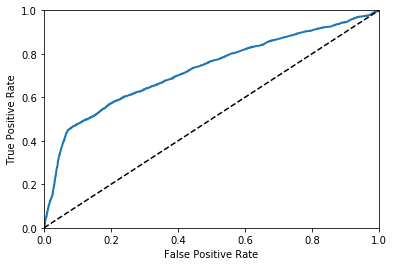

In [16]:
# one more way of evaluating the model, the ROC curve:

y_scores = logit_ridge.decision_function(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [17]:
# Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores:
roc_auc_score(y_train, y_scores) # to be compared with other models.


0.7264232148808616

### Handling Class Imbalance

Before trying different models and select one and trying to perfect our prediction (especially recall), we have to handle the large class imbalance in the data. It has to be done before model selection, as it can have a different influence on the model that we will test after.   

There are several ways of addressing class imbalance that I will try:  

* Over-sampling of minority class; and even "synthetic" over-sampling, using SMOTE
* Under-sampling of majority class
* Use another metrics that accuracy to evaluate the model. I will try the Area Under Roc Curve (AUROC); it represents the likelihood of your model distinguishing observations from two classes
* Penalize the algorithm by increasing the cost of classification mistakes on the minority class. I already tried this by using the argument *class_weight='balanced'* when fitting the logistic regression.

#### SMOTE

I will try SMOTE to balance the data. Oversampling has to be done on training data alone ([see comment](https://beckernick.github.io/oversampling-modeling)). Oversampling can lead to bad generalization, that is why we will test the generalizibility on a validation set.

In [18]:
# adapted from this: https://www.kaggle.com/qianchao/smote-with-imbalance-data

print("Number of water systems in X_train dataset: ", X_train.shape)
print("Number of water systems in y_train dataset: ", y_train.shape)
print("Number of water systems in X_valid dataset: ", X_valid.shape)
print("Number of water systems in y_valid dataset: ", y_valid.shape)
print("Number of water systems in X_test dataset: ", X_test.shape)
print("Number of water systems in y_test dataset: ", y_test.shape)

Number of water systems in X_train dataset:  (41884, 29)
Number of water systems in y_train dataset:  (41884,)
Number of water systems in X_valid dataset:  (10471, 29)
Number of water systems in y_valid dataset:  (10471,)
Number of water systems in X_test dataset:  (10471, 29)
Number of water systems in y_test dataset:  (10471,)


In [19]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=51) 
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel()) # oversampling
# SMOTE is about oversampling minority class, BUT while SMOTE still oversamples the minority class, 
# it does not rely on reusing previously existing observations. 
# Instead, SMOTE creates new (synthetic) observations based on the observations in your data.
# see https://towardsdatascience.com/a-deep-dive-into-imbalanced-data-over-sampling-f1167ed74b5

print('After OverSampling, the shape of X_train: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 4529
Before OverSampling, counts of label '0': 37355 

After OverSampling, the shape of X_train: (74710, 29)
After OverSampling, the shape of y_train: (74710,) 

After OverSampling, counts of label '1': 37355
After OverSampling, counts of label '0': 37355


I will now use *X_train_res* and *y_train_res* to train the model. Let's quickly try again with the previous logistic regression model.

In [20]:
# Fitting the model with the chosen regularization:
logit_ridge = LogisticRegression(penalty='l2', solver='liblinear', C=0.001)
logit_ridge.fit(X_train_res, y_train_res)
y_pred = logit_ridge.predict(X_train_res)
print(classification_report(y_train_res, y_pred))


              precision    recall  f1-score   support

         0.0       0.63      0.90      0.74     37355
         1.0       0.83      0.48      0.60     37355

    accuracy                           0.69     74710
   macro avg       0.73      0.69      0.67     74710
weighted avg       0.73      0.69      0.67     74710



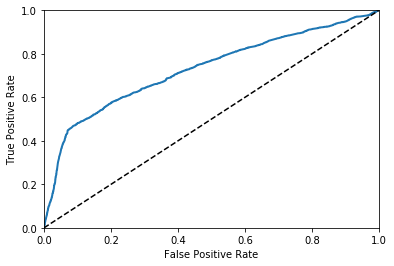

AUROC: 0.7292161291630453


In [21]:
y_scores = logit_ridge.decision_function(X_train_res)
AUROC = roc_auc_score(y_train_res, y_scores)
fpr, tpr, thresholds = roc_curve(y_train_res, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()
print('AUROC: ' + str(AUROC))

So we lost general accuracy (from 0.86 to 0.69), but the precision was improved for the positive samples. The AUC is very similar.

#### Under-sampling Majority Class

We sample without replacement the majority class until obtaining the same number of rows as the minority class. Disadvantage: you lose some data.

In [22]:
# Separate majority and minority classes
df_majority = data_train[data_train.had_violation==0]
df_minority = data_train[data_train.had_violation==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=4529,     # to match minority class
                                 random_state=51) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.had_violation.value_counts()

1.0    4529
0.0    4529
Name: had_violation, dtype: int64

In [23]:
# Let's try to fit the logistic regression again:

X_train_down = df_downsampled.drop('had_violation', axis=1)
y_train_down = df_downsampled.had_violation

logit_ridge = LogisticRegression(penalty='l2', solver='liblinear', C=0.001)
logit_ridge.fit(X_train_down, y_train_down)
y_pred = logit_ridge.predict(X_train_down)
print(classification_report(y_train_down, y_pred))



              precision    recall  f1-score   support

         0.0       0.64      0.85      0.73      4529
         1.0       0.77      0.51      0.62      4529

    accuracy                           0.68      9058
   macro avg       0.70      0.68      0.67      9058
weighted avg       0.70      0.68      0.67      9058



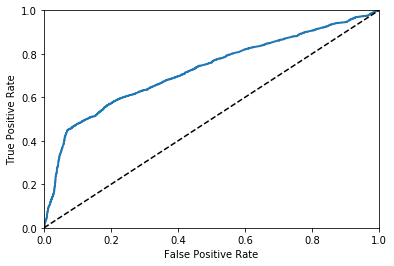

AUROC: 0.7245120513560924


In [24]:
y_scores = logit_ridge.decision_function(X_train_down)
AUROC = roc_auc_score(y_train_down, y_scores)
fpr, tpr, thresholds = roc_curve(y_train_down, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()
print('AUROC: ' + str(AUROC))

The results are similare to SMOTE...

**Summary and decision:**

AUROC obtained:

1. Cost-Sensitive Training (class_weight='balanced'):   0.7264
2. Over-sampling minority class (SMOTE):                0.7292
3. Under-sampling majority class:                       0.7245

**I will use SMOTE as strategy to handle class imbalance and use AUROC to compare and select my models (instead of accuracy).**  

### Training and Model Selection

I will compare _logistic regression_, _gradient boosting_ and _random forest_ abilitity to classify the water systems that had a violation of drinking water quality.  

#### Training the Logistic Regression


In [36]:
# find the desired parameters
logistic = LogisticRegression(solver='liblinear')  
parameters_grid = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
logistic_search = GridSearchCV(estimator=logistic, scoring='au_roc', param_grid=parameters_grid, cv=5)
logistic_search.fit(X_train_res, y_train_res) # using the SMOTE resampled training set

print('Best C:',logistic_search.best_estimator_.C)
print('The mean cross-validated score of the best_estimator on X_train:', logistic_search.best_score_)
print('Accuracy on (full) X_train: ' + str(logistic_search.score(X_train_res, y_train_res)))

Best C: 1e-05
The mean cross-validated score of the best_estimator on X_train: 0.38238522286173204
Accuracy on (full) X_train: 0.6739392316958908


I choose a parameter C of 0.00001, the CV would prefer the smallest possible (without much gain), but I think that it is already reasonably small.

In [39]:
# train chosen model:
logistic = LogisticRegression(solver='liblinear', C=0.00001)
logistic.fit(X_train_res, y_train_res)


LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [70]:
# Evaluating the model:

y_pred = logistic.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

y_scores = logistic.decision_function(X_train_res)
AUROC_logistic = roc_auc_score(y_train_res, y_scores) # store AUROC to compare with the other models
print("AUROC: " + str(AUROC_logistic))

              precision    recall  f1-score   support

         0.0       0.66      0.73      0.69     37355
         1.0       0.69      0.62      0.66     37355

    accuracy                           0.67     74710
   macro avg       0.68      0.67      0.67     74710
weighted avg       0.68      0.67      0.67     74710

AUROC: 0.7253639654018651


In [99]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[27134 10221]
 [14139 23216]]
Normalized confusion matrix
[[0.73 0.27]
 [0.38 0.62]]


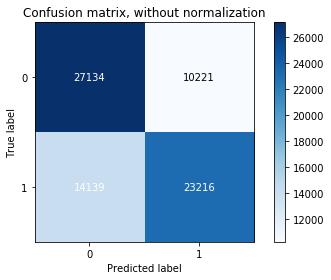

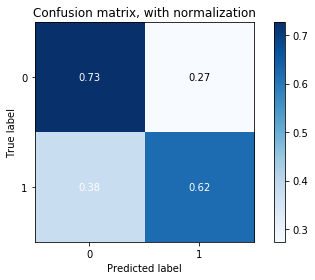

In [100]:
plot_confusion_matrix(y_train_res, y_pred, normalize=False,
                      title='Confusion matrix, without normalization')

plot_confusion_matrix(y_train_res, y_pred, normalize=True,
                      title='Confusion matrix, with normalization')

plt.show()

#### Training the Gradient Boosting

In [119]:
# Fix learning rate and number of estimators before tuning tree-based parameters
# first we find right learning rate for the number of estimators

# see this: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

# note: after a first run, I increase the learning rate to 0.2, as the best n_estimators was the upper limit

t0 = time.time()
# define parameters grid:
param_grid = {'n_estimators': range(60,101,10)}

# Initialize and fit the model.
grad_boost = GradientBoostingClassifier(learning_rate=0.2, min_samples_split=500, 
                                        min_samples_leaf=50, max_depth=8, 
                                        max_features='sqrt', subsample=0.8, 
                                        random_state=10)
# min_samples_split good if 05-1% of sample size.
search_grad_boost = GridSearchCV(grad_boost, param_grid, cv=5,
                                scoring='roc_auc') # AND NOT THE ACCURACY!

search_grad_boost.fit(X_train_res, y_train_res)

print("time needed: " + str(t0 - time.time()))

print('Best n_estimators:', search_grad_boost.best_estimator_.n_estimators)
print('The mean cross-validated score of the best_estimator on X_train:', search_grad_boost.best_score_)
print('AUROC on (full) X_train: ' + str(search_grad_boost.score(X_train_res, y_train_res)))


time needed: -107.43925786018372
Best n_estimators: 100
The mean cross-validated score of the best_estimator on X_train: 0.3704805092876769
Accuracy on (full) X_train: 0.8670137952413903


I will stick with a learning rate of 0.2 and 100 estimators. By increasung the number of estimators it will just get too long to train the model and search for the best paramaters.

In [120]:
### Tuning tree-specific parameters
# The most important first:  max_depth and min_samples_split

t0 = time.time()
# define parameters grid:
param_grid = {'max_depth':range(12,22,3), 
              'min_samples_split':range(100,301,100)
             }

# Initialize and fit the model.
grad_boost = GradientBoostingClassifier(learning_rate=0.2, n_estimators = 100,
                                        min_samples_leaf=50,  
                                        max_features='sqrt', subsample=0.8, 
                                        random_state=10)
search_grad_boost = GridSearchCV(grad_boost, param_grid, cv=5,
                                scoring='roc_auc')

search_grad_boost.fit(X_train_res, y_train_res)

print("time needed: " + str(t0 - time.time()))

print('Best max_depth:', search_grad_boost.best_estimator_.max_depth)
print('Best min_samples_split:', search_grad_boost.best_estimator_.min_samples_split)
print('The mean cross-validated score of the best_estimator on X_train:', search_grad_boost.best_score_)
print('AUROC on (full) X_train: ' + str(search_grad_boost.score(X_train_res, y_train_res)))

time needed: -584.7222900390625
Best max_depth: 15
Best min_samples_split: 100
The mean cross-validated score of the best_estimator on X_train: 0.399514687953909
Accuracy on (full) X_train: 0.9179259794723866


The best max depth is 15. I will stay with a min_samples_split of 100, not going below as usually it should be around 0.5-1% of the sample size (74000). It is probably an indication of overfitting. If I have more time, I might consider a second iteration of this GridSearchCV.

In [121]:
### Tuning tree-specific parameters
# Then min_samples_leaf

t0 = time.time()
# define parameters grid:
param_grid = {'min_samples_leaf': range(30,71,10)}

# Initialize and fit the model.
grad_boost = GradientBoostingClassifier(learning_rate=0.2, n_estimators = 100,
                                        max_depth=15, min_samples_split=100,
                                        max_features='sqrt', subsample=0.8, 
                                        random_state=10)
search_grad_boost = GridSearchCV(grad_boost, param_grid, cv=5,
                                scoring='roc_auc')

search_grad_boost.fit(X_train_res, y_train_res)

print("time needed: " + str(t0 - time.time()))

print('Best min_samples_leaf:', search_grad_boost.best_estimator_.min_samples_leaf)
print('The mean cross-validated score of the best_estimator on X_train:', search_grad_boost.best_score_)
print('AUROC on (full) X_train: ' + str(search_grad_boost.score(X_train_res, y_train_res)))


time needed: -276.45716404914856
Best min_samples_leaf: 30
The mean cross-validated score of the best_estimator on X_train: 0.40150508168460636
AUROC on (full) X_train: 0.9249017288837411


**TO DO: 2nd iteration for min_samples_leaf, and tune the other parameters.**

In [123]:
# train chosen model:
grad_boost = GradientBoostingClassifier(learning_rate=0.2, n_estimators = 100,
                                        max_depth=15, min_samples_split=100,
                                        min_samples_leaf=30,
                                        max_features='sqrt', subsample=0.8)
grad_boost.fit(X_train_res, y_train_res)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=15,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=30, min_samples_split=100,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

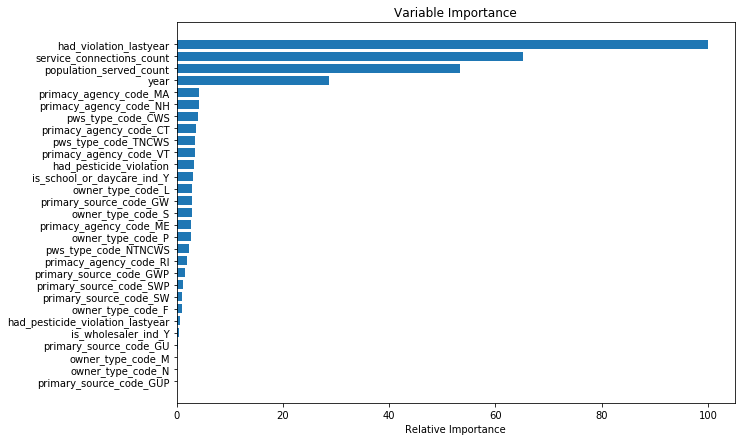

In [144]:
feature_importance = grad_boost.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,7))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, data_train.drop('had_violation', axis=1).columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

**Evaluating the Gradient Boosting on the train set**:

In [133]:
# Evaluating the model:

y_pred = grad_boost.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

y_scores = grad_boost.decision_function(X_train_res)
AUROC_gradboost = roc_auc_score(y_train_res, y_scores) # store AUROC to compare with the other models
print("AUROC: " + str(AUROC_gradboost))

              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85     37355
         1.0       0.88      0.79      0.84     37355

    accuracy                           0.84     74710
   macro avg       0.85      0.84      0.84     74710
weighted avg       0.85      0.84      0.84     74710

AUROC: 0.9252275005584883


Confusion matrix, without normalization
[[33467  3888]
 [ 7781 29574]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.21 0.79]]


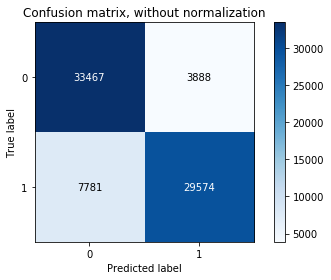

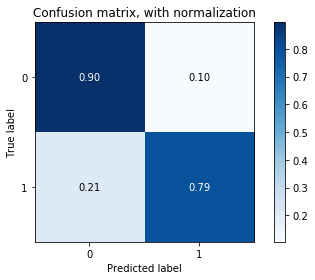

In [134]:
plot_confusion_matrix(y_train_res, y_pred, normalize=False,
                      title='Confusion matrix, without normalization')

plot_confusion_matrix(y_train_res, y_pred, normalize=True,
                      title='Confusion matrix, with normalization')

plt.show()

In [145]:
# Overfitting? (here the accuracy)
cross_val_score(grad_boost, X_train_res, y_train_res, cv=10) 
# ==> There is some overfitting apparently as the scores are varying

array([0.68, 0.76, 0.77, 0.69, 0.58, 0.67, 0.77, 0.77, 0.58, 0.5 ])

It will be important to evaluate these models with their performance on the validation set.

### Random Forest

Disadvantage: harder to interpret the results.  
I use RandomizedSearchCV instead of GridSearchCV, to gain time.

In [157]:
# Use the random grid to search for best hyperparameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


t0 = time.time()
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1,
                              scoring='roc_auc')
# Fit the random search model
rf_random.fit(X_train_res, y_train_res)

print("tuned in " + str(time.time() - t0) + 'seconds')

print('best params: ' + str(rf_random.best_params_))
print('The mean cross-validated AUROC of the best_estimator on X_train:', rf_random.best_score_)
print('AUROC on (full) X_train: ' + str(rf_random.score(X_train_res, y_train_res)))


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 57.8min finished


tuned in 3597.9461708068848seconds
best params: {'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}
The mean cross-validated AUROC of the best_estimator on X_train: 0.5328558140916086
AUROC on (full) X_train: 0.9894741827862094


Let's quickly evaluate the performance of this model on the train set:

In [159]:
# train chosen model: ! take 5 min
rf = RandomForestClassifier(n_estimators=1400, min_samples_split=2, min_samples_leaf=1, 
                            max_features='auto', max_depth=40, bootstrap=False)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=40, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [162]:
y_pred = rf.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

# This code does not work for random forest, I will compute this on the validation set later
# y_scores = rf.decision_function(X_train_res)
# AUROC_randomforest = roc_auc_score(y_train_res, y_scores) # store AUROC to compare with the other models
# print("AUROC: " + str(AUROC_randomforest))

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94     37355
         1.0       0.96      0.91      0.94     37355

    accuracy                           0.94     74710
   macro avg       0.94      0.94      0.94     74710
weighted avg       0.94      0.94      0.94     74710



Confusion matrix, without normalization
[[36078  1277]
 [ 3252 34103]]
Normalized confusion matrix
[[0.97 0.03]
 [0.09 0.91]]


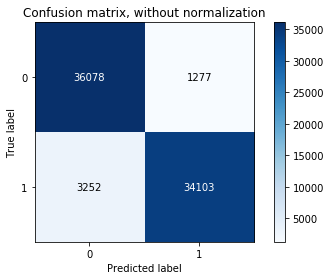

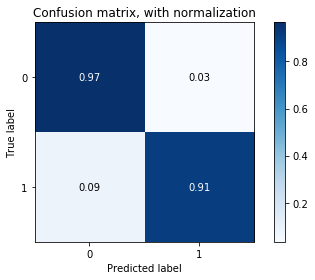

In [161]:
plot_confusion_matrix(y_train_res, y_pred, normalize=False,
                      title='Confusion matrix, without normalization')
plot_confusion_matrix(y_train_res, y_pred, normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

In [ ]:
# Maybe run this if have time
# # Overfitting? (here the accuracy) 
# cross_val_score(fit, X_train_res, y_train_res, cv=10) 
# # ==> There is some overfitting apparently as the scores are varying

The model looks promising as it has a good AUROC (0.98), a good recall and precision. However, I am afraid that it might be overfitting.  


### Testing the Models on the Validation Set

I test the generalizability of the 3 trained models on the validation set. The AUROC will be my main criterion to choose a model.   

I will then pick my favorite model, maybe fine-tune it a bit more, and then finally test it on the test set.

In [220]:
# TAKES 3min.
# Fitting the 3 models and evalutating them on the train and validation set:

def model_evaluation(model_name, model, X_train, y_train, X_test, y_test):
    # a function that fits the desired models on the train set, 
    # and evaluate them both and train and validation or test set.
    
    training_fit = model.fit(X_train, y_train) # the training. fit is stored and reused below
    
    # evaluation on train set:
    y_pred_train = training_fit.predict(X_train)
    y_predproba_train = training_fit.predict_proba(X_train)
    Accuracy_train = training_fit.score(X_train, y_train)
    AUROC_train = roc_auc_score(y_train, y_predproba_train[:,1])
    recall_train = recall_score(y_train, y_pred_train)
    
    # evaluation on validation set:
    y_pred_valid = training_fit.predict(X_valid) # predicted y on validation set using model trained on train set
    y_predproba_valid = training_fit.predict_proba(X_valid)
    Accuracy_valid = training_fit.score(X_valid, y_valid)
    AUROC_valid = roc_auc_score(y_valid, y_predproba_valid[:,1])
    recall_valid = recall_score(y_valid, y_pred_valid)
    
    # printing results:
    print(model_name)
    print('')
    print("Accuracy on train set: " + str(Accuracy_train))
    print("AUROC on train set: " + str(AUROC_train))
    print("recall on train set: " + str(recall_train))
    print('')
    print("Accuracy on validation set: " + str(Accuracy_valid))
    print("AUROC on validation set: " + str(AUROC_valid))
    print("recall on validation set: " + str(recall_valid))
    print('\n\n')

# Logistic Regression with Ridge Regularization
log = LogisticRegression(solver='liblinear', C=0.00001, penalty='l2')
model_evaluation("Logistic regression with ridge regularization", log, 
                 X_train_res, y_train_res, X_valid, y_valid)

# Gradient boosting
gb = GradientBoostingClassifier(learning_rate=0.2, n_estimators = 100,
                                        max_depth=15, min_samples_split=100,
                                        min_samples_leaf=30,
                                        max_features='sqrt', subsample=0.8)
model_evaluation("Gradient Boosting", gb, 
                 X_train_res, y_train_res, X_valid, y_valid)

rf = RandomForestClassifier(n_estimators=1400, min_samples_split=2, min_samples_leaf=1, 
                            max_features='auto', max_depth=40, bootstrap=False, n_jobs = -1)
model_evaluation("Random Forest", rf, 
                 X_train_res, y_train_res, X_valid, y_valid)




Logistic regression with ridge regularization

Accuracy on train set: 0.6739392316958908
AUROC on train set: 0.7253639654018651
recall on train set: 0.6214964529514121

Accuracy on validation set: 0.7412854550663738
AUROC on validation set: 0.6804825155099374
recall on validation set: 0.54178145087236



Gradient Boosting

Accuracy on train set: 0.8450140543434613
AUROC on train set: 0.9257717360202457
recall on train set: 0.7908981394726275

Accuracy on validation set: 0.834877280106962
AUROC on validation set: 0.6940191238169959
recall on validation set: 0.43709825528007346



Random Forest

Accuracy on train set: 0.9393923169589078
AUROC on train set: 0.9894722607512086
recall on train set: 0.9128630705394191

Accuracy on validation set: 0.874606054818069
AUROC on validation set: 0.6973966325529279
recall on validation set: 0.3682277318640955





There is a large drop in AUROC for all models, particularly in gradient boosting and random forest, between the train set and the validation set: **The models are overfitting.**  

I will try to reduce the max_depth and n_estimator in the gradient boosting and randome forest (as a first priority), and try to reduce the C in the ridge regression.  

### New Training Iteration with the Aim to Reduce Overfitting

**Logistic Regression with Ridge Regularization**

In [229]:
# Logistic regression
logistic = LogisticRegression(solver='liblinear', penalty='l2')  
parameters_grid = {'C':[1e-20, 1e-17, 1e-15, 1e-13, 1e-12, 1e-11, 1e-10, 1e-8, 1e-5]}
logistic_search = GridSearchCV(estimator=logistic, scoring='roc_auc', param_grid=parameters_grid, cv=3) # 3 folds
logistic_search.fit(X_train_res, y_train_res) # using the SMOTE resampled training set

print('Best C:',logistic_search.best_estimator_.C)
print('The mean cross-validated score of the best_estimator on X_train:', logistic_search.best_score_)
print('Accuracy on (full) X_train: ' + str(logistic_search.score(X_train_res, y_train_res)))

Best C: 1e-12
The mean cross-validated score of the best_estimator on X_train: 0.5315422839235824
Accuracy on (full) X_train: 0.7256745589482384


I choose a C regalurization parameter of 1e-12, knowing that a smaller C means more regularization thus potentially less risk of overfitting. It was the best C with a 3- and 5-folds CV. A 10-folds CV give a best parameter of 1e-11. Let's test the generalization on the validation set:

In [230]:
# evaluation on validation set:
log = LogisticRegression(solver='liblinear', C=1e-12, penalty='l2')
model_evaluation("Logistic regression with ridge regularization", log, 
                 X_train_res, y_train_res, X_valid, y_valid)
# WAS PREVIOUSLY:
# Accuracy on validation set: 0.7412854550663738
# AUROC on validation set: 0.6804825155099374
# recall on validation set: 0.54178145087236

Logistic regression with ridge regularization

Accuracy on train set: 0.6622406639004149
AUROC on train set: 0.7256849015318071
recall on train set: 0.6580377459510106

Accuracy on validation set: 0.6735746347053767
AUROC on validation set: 0.6813106452599874
recall on validation set: 0.5711662075298439





The accuracy is worse than before, the AUROC is similar and the recall is a bit better.  

**Gradient Boosting:**

In [232]:
# Gradient Boosting
# The most important to control for overfitting:  max_depth and n_estimator
# the max parameter values are smaller than before.

smaller_n_estimators = 50 # instead of 100
smaller_max_depth = 8 # instead of 15

gb = GradientBoostingClassifier(n_estimators = smaller_n_estimators,
                                max_depth=smaller_max_depth, 
                                learning_rate=0.2, min_samples_split=100, min_samples_leaf=30,
                                max_features='sqrt', subsample=0.8)

model_evaluation("Gradient Boosting", gb, 
                 X_train_res, y_train_res, X_valid, y_valid)
# WAS PREVIOUSLY (that is want we want to beat):
# Accuracy on validation set: 0.834877280106962
# AUROC on validation set: 0.6940191238169959
# recall on validation set: 0.43709825528007346

Gradient Boosting

Accuracy on train set: 0.7622406639004149
AUROC on train set: 0.8484110512641025
recall on train set: 0.6358452683710347

Accuracy on validation set: 0.8442364626110209
AUROC on validation set: 0.7001735734899821
recall on validation set: 0.4490358126721763





The AUROC and recall were only slightly improved. Let's try to reduce them more:

In [240]:
smaller_n_estimators = 50 # instead of 100
smaller_max_depth = 8 # instead of 15

gb = GradientBoostingClassifier(n_estimators = smaller_n_estimators,
                                max_depth=smaller_max_depth, 
                                learning_rate=0.2, min_samples_split=100, min_samples_leaf=30,
                                max_features='sqrt', subsample=0.8)

model_evaluation("Gradient Boosting", gb, 
                 X_train_res, y_train_res, X_valid, y_valid)
# WAS PREVIOUSLY (that is want we want to beat):
# Accuracy on validation set: 0.834877280106962
# AUROC on validation set: 0.6940191238169959
# recall on validation set: 0.43709825528007346

Gradient Boosting

Accuracy on train set: 0.7622808191674475
AUROC on train set: 0.8503376183116187
recall on train set: 0.6381207335028778

Accuracy on validation set: 0.8353547894183937
AUROC on validation set: 0.696925456968867
recall on validation set: 0.4554637281910009





# TO DO

1. train random forest
2. (eventually fine tune gradient boosting even more)
3. compare AUROC of models on train set, just one sentence
4. fit models on validation set, compute ROC, AUROC
5. Choose best model, fit it on test set
6. Discuss. Propose how to make it better
7. eventually try with had_pesticides and add pesticide use by county in the model.

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.2,
                                                  loss='deviance', max_depth=15,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=100,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  pre